In [ ]:
import numpy as np
import torch
import pandas as pd
import os, sys, math
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from numpy.matlib import repmat
from scipy.io import loadmat
from functools import reduce
from operator import mul
import argparse
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import shutil
import ast
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy.matlib
import pdb
import scipy.stats
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#%%capture
#%cd /content/drive/MyDrive/11785FinalProject
#!unzip LA.zip -d /root

In [ ]:
#Install other dependencies
#!pip install python_speech_features
#!apt-get install libsox-fmt-all libsox-dev sox > /dev/null
#!pip install tqdm
#!pip install zipfile
#!pip install pytest-shutil
#!pip install multiprocessing

In [ ]:
#Save flac as wav files

import time
from tqdm import tqdm

def flac_to_wav(flacfiles, original_path, save_path):
  outfile = [f.replace('.flac', '.wav') for f in flacfiles]
  for i in tqdm(range(len(flacfiles))):
    cmd = 'sox ' + original_path + flacfiles[i] + " " + save_path + outfile[i]
    x = os.system(cmd)
    if(x != 0):
      print("failed")
      break

devpath = "/root/LA/ASVspoof2019_LA_dev/flac"
trainpath = "/root/LA/ASVspoof2019_LA_train/flac"
evalpath = "/root/LA/ASVspoof2019_LA_eval/flac"
savepath = "/root/LA2/ASVspoof2019_LA_dev/wav/"
devfiles = os.listdir(devpath)
trainfiles = os.listdir(trainpath)
evalfiles = os.listdir(evalpath)
flac_to_wav(trainfiles, original_path = trainpath + "/", save_path = "/content/drive/MyDrive/11785FinalProject/data/train/")
#flac_t_wav(trainfiles)

'import time\nfrom tqdm import tqdm\n\ndef flac_to_wav(flacfiles, original_path, save_path):\n  outfile = [f.replace(\'.flac\', \'.wav\') for f in flacfiles]\n  for i in tqdm(range(len(flacfiles))):\n    cmd = \'sox \' + original_path + flacfiles[i] + " " + save_path + outfile[i]\n    x = os.system(cmd)\n    if(x != 0):\n      print("failed")\n      break\n'

In [ ]:
#!zip -r '/content/drive/MyDrive/11785FinalProject/train_data.zip' '/content/drive/MyDrive/11785FinalProject/data/train/'

In [ ]:
# Dataset construction / dataloading
class MelBankDataset(Dataset):
	def __init__(self, data, names, keys, crop_size, dtype, gender_dict=None, colname = None):
		self.data = data
		self.keys = keys
		self.names = names
		self.crop_size = crop_size
		self.dtype = dtype
		self.unit = np.dtype(dtype).itemsize
		self.EXTEND = True
		self.gender_dict = gender_dict
		self.gender = {'m':0, 'f':1}
		self.colname = colname

	def __len__(self):
		return len(self.data)
	
	def _read_feat(self, index):
		#Currently it is (time, frequency)
		## IMP ##
		## Check the dimension here. Im not sure whether it would be (Time, Freq) or (Freq, Time). 
		## Following function usage may change depending on this shape. Confirm before continuing.
		cqcc = np.load(self.file_list[index])
		return cqcc
		
	def _extend_feat(self, feat, EXTEND):
		height, width = (200, 40) # cqcc
		if EXTEND:
			B = repmat(feat,int(math.ceil(height/(feat.shape[0]))), 1)
			C = B.reshape(-1,width)
			D = C[:height,:]
		if not EXTEND: D = feat
		## normalizing ##
		frame_n = 300
		for s_pt in range(0, D.shape[0], frame_n):
			e_pt = min(s_pt+frame_n, D.shape[0])
			D[s_pt:e_pt, :] = D[s_pt:e_pt, :] - D[s_pt:e_pt, :].mean(axis=0)
			D[s_pt:e_pt, :] = D[s_pt:e_pt, :] / (D[s_pt:e_pt, :].std(axis=0)+np.finfo(np.float16).eps)
		D=D.astype('float32').transpose()[np.newaxis, ...]
		return D

	def __getitem__(self, index):
		basename = self.names[index][0]
		labels = self.keys[self.keys[self.colname]== basename]
		gend_label = self.gender_dict[labels.iloc[0].iloc[0]]
		if(gend_label == "u-m"):
			gend_label = "m"
		gender = self.gender[gend_label]
		device = 0 if labels.iloc[0].iloc[3] == "-" else 1
		data = self.data[index][0]
		data = self._extend_feat(data, self.EXTEND)
		return (basename, data, gender, device)

In [ ]:
train_names = np.load("/content/drive/MyDrive/11785FinalProject/data/train_names.npy")
train_data = np.load("/content/drive/MyDrive/11785FinalProject/data/train.npy", allow_pickle = True)
dev_names = np.load("/content/drive/MyDrive/11785FinalProject/data/dev_names.npy")
dev_data = np.load("/content/drive/MyDrive/11785FinalProject/data/dev.npy", allow_pickle = True)

In [ ]:
#Model
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Unflatten(nn.Module):
    def __init__(self, channel, height, width):
        super(Unflatten, self).__init__()
        self.channel = channel
        self.height = height
        self.width = width
    def forward(self, input):
        return input.view(input.size(0), self.channel, self.height, self.width)

class ConvVAE(nn.Module):
    def __init__(self, latent_size):
        super(ConvVAE, self).__init__()
        self.latent_size = latent_size
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=(3,3), stride=(1,2), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(256, 256, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(256, 128, kernel_size=(5,5), stride=(2,2), padding=(2,2)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(128,128, kernel_size = (3,3), stride = (1,1), padding = (1,1)),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(128,64, kernel_size = (3,3), stride = (1,1), padding = (1,1)),
            nn.ReLU(),
            Flatten(),
            nn.Linear(64000, self.latent_size * 2),
            nn.ReLU()
        )
        # hidden => mu
        self.fc1 = nn.Linear( self.latent_size * 2, self.latent_size)
        # hidden => logvar
        self.fc2 = nn.Linear( self.latent_size * 2, self.latent_size)

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_size+1,  self.latent_size * 2),
            nn.ReLU(),
            nn.Linear( self.latent_size * 2, 64000),
            nn.ReLU(),
            Unflatten(64,  20 , 50),
            nn.ReLU(),
            nn.ConvTranspose2d(64,128, kernel_size = (3,3), stride = (1,1), padding = (1,1)),
            nn.ReLU(),
            nn.ConvTranspose2d(128,128, kernel_size = (3,3), stride = (1,1), padding = (1,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 256, kernel_size=(5,5), stride=(2,2), padding=(2,2)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, kernel_size=(3,4), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 1, kernel_size=(4,4), stride=(1,2), padding= (1,1)),
            nn.Sigmoid()
        )
    def encode(self, x, gender= None):
        h = self.encoder(x)
        mu, logvar = self.fc1(h), self.fc2(h) #logvar not actually log 
        return mu, logvar

    def decode(self, z):
        z = self.decoder(z)
        return z

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def reparameterize_eval(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x, gender, do_cf = True):
        #pdb.set_trace()
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar) #(Batch size, latentsize)
        z1 = torch.cat((z, gender[:,None]), dim = 1) #(Batch size, latentsize + 1)
        cf_res =0
        if(do_cf): 
          counterfact = torch.cat((z, torch.logical_not(gender)[:,None]), dim = 1) #(batchsize, latentsize+1)
          cf_res = self.decode(counterfact)
        return self.decode(z1), cf_res, mu, logvar

In [ ]:
def filter_one(audio_data, names, keys, colname):
  rows = keys["bonafide"] == "bonafide"
  bona_files = []
  bona_names = []
  indices = keys.index
  bona_ind = indices[rows]
  for row in bona_ind:
    d = keys.iloc[row]
    filename= d.loc[colname] 
    where = np.where(names == filename)
    bona_files.append(audio_data[where])
    bona_names.append(names[where])

  rows2 = keys["bonafide"] != "bonafide"
  fake_ind = indices[rows2]
  fake_files = []
  fake_names = []
  for row in fake_ind:
    d = keys.iloc[row]
    filename= d.loc[colname]
    where = np.where(names == filename)
    fake_files.append(audio_data[where])
    fake_names.append(names[where])
  return bona_files, bona_names, fake_files, fake_names
 
data = np.concatenate((train_data, dev_data), axis = 0)
names = np.concatenate((train_names, dev_names), axis = 0)

b_files, b_names, f_files, f_names = filter_one(data, names, keys, colname = "Filename")


In [ ]:
#Train segment
cuda = torch.cuda.is_available()
if cuda:
    print('cuda available')

device = torch.device("cuda" if cuda else "cpu")

def pvalue(predicted, mean, var):
    z = (predicted - mean) / var
    pval = scipy.stats.norm.sf(np.abs(z))
    #If pval is less than 1-alpha, predict False. If pval >= 1-alpha, predict True (it is from the distribution)
    return pval


def loss_function(recon_x, x, mu, logvar):
    # reconstruction loss
    rshape = recon_x.shape
    xshape = x.shape
    x = torch.softmax(x, 3)
    logvar = torch.exp(logvar)
    BCE = F.binary_cross_entropy(recon_x.view(-1, rshape[0] * rshape[1]*rshape[2]*rshape[3]), (x.view(-1, xshape[0]*xshape[1]*xshape[2]*xshape[3])), reduction = "mean")
    RMSE = torch.sqrt(F.binary_cross_entropy(recon_x.view(rshape[0], rshape[1]*rshape[2]*rshape[3]), x.view(xshape[0], xshape[2]*xshape[1]*xshape[3]), reduction = "none").mean(dim = 1))
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, RMSE.detach().cpu().numpy()

### Training #####
def train(epoch, model, train_loader, optimizer, args, device):
    mse = nn.MSELoss()
    model.train()
    train_loss = 0
    rmse_real, rmse_fake = [], []
    gender0mse, gender1mse = 0,0
    num_zeros, num_ones = 1,1
    for batch_idx, (basename, data, gender, device_) in enumerate(train_loader):
        data,gender = data.to(device), gender.to(device)
        optimizer.zero_grad()
        recon_batch, counter_factual, mu, logvar = model(data, gender)
        zeros = (gender == 0)#.nonzero().detach().numpy()
        ones = (gender == 1)#.nonzero().detach().numpy()
        num_zeros += len(zeros)
        num_ones += len(ones)
        loss, rmse = loss_function(recon_batch, data, mu, logvar)
        rmse_real.extend(rmse)
        nan_count = torch.sum(torch.isnan(recon_batch))
        if(nan_count.item() != 0):
          pdb.set_trace()
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader.dataset)
    gender0mse /= num_zeros
    gender1mse /= num_ones
    torch.cuda.empty_cache()
    del gender
    del data
    del recon_batch
    del mu
    del logvar
    del loss
    del rmse
    del zeros
    del ones
    return train_loss, np.asarray(rmse_real), gender0mse, gender1mse

### Validating ####
def test(epoch, model, test_loader, args, rmse_real, device, threshold):
    model.eval()
    test_loss = 0
    mse = nn.MSELoss()
    percentile_val = np.percentile(rmse_real, threshold)
    print("percentile info: ", "threshold: ", round(percentile_val,5), "mean: ", round(np.mean(rmse_real),5))
    mean, var = np.mean(rmse_real), np.std(rmse_real)
    test_acc = 0
    test_auc = 0
    test_f1 = 0
    num_zeros, num_ones = 1,1
    gender0mse, gender1mse = 0,0
    total = 0
    rmse_0, rmse_1 = [],[]
    rmse_male, rmse_female = [], []
    stop_point = int(len(test_loader) * 0.7)
    rmse_fake_f, rmse_fake_m = [],[]
    with torch.no_grad():
        for batch_idx, (basename, data, gender, device_) in enumerate(test_loader):
            data,gender1 = data.to(device), gender.to(device)
            recon_batch,counter_factual, mu, logvar = model(data, gender1, True)
            loss, rmse = loss_function(recon_batch, data, mu, logvar)
            
            zeros = (gender == 0)#.nonzero().detach().numpy()
            ones = (gender == 1)#.nonzero().detach().numpy()
            gender0mse += mse(recon_batch[zeros], counter_factual[zeros]).item()
            gender1mse += mse(recon_batch[ones], counter_factual[ones]).item()
            num_zeros += len(zeros)
            num_ones += len(ones)

            zeros_g = (gender == 0).nonzero().detach().numpy()
            ones_g = (gender == 1).nonzero().detach().numpy()
            rmse_male.extend(rmse[zeros_g].tolist())
            rmse_female.extend(rmse[ones_g].tolist())


            zeros_d = (device_ == 0).nonzero().detach().numpy()
            ones_d = (device_ == 1).nonzero().detach().numpy()
            rmse_0.extend(rmse[zeros_d].tolist())
            rmse_1.extend(rmse[ones_d].tolist())

            female_fake = np.intersect1d(ones_d, ones_g)
            male_fake = np.intersect1d(ones_d, zeros_g)
            rmse_fake_f.extend(rmse[female_fake])
            rmse_fake_m.extend(rmse[male_fake])
            
            pred = (torch.from_numpy(rmse) > percentile_val).float() # > for training on bona
            #pred = (torch.from_numpy(rmse) < percentile_val).float() # < for training on fake
            acc = (pred == device_).float().sum()
            f1_score = metrics.f1_score(device_, pred)
            test_loss += loss.item()
            test_acc += acc.item()
            #test_auc += auc
            test_f1 += f1_score
            total += data.shape[0]
    test_loss /= total
    test_acc /= total
    test_auc /= total
    test_f1 /= len(test_loader)
    gender0mse /= num_zeros
    gender1mse /= num_zeros
    del data
    del recon_batch
    del mu
    del logvar
    del rmse
    return test_loss, test_acc, test_auc, test_f1, rmse_1, rmse_0, gender0mse, gender1mse, rmse_male, rmse_female, rmse_fake_m, rmse_fake_f

def valid(epoch, model, test_loader, args, rmse_real, device, threshold):
    model.eval()
    test_loss = 0
    mse = nn.MSELoss()
    #threshold = 90 #80 #70 #80 #90
    percentile_val = np.percentile(rmse_real, threshold)
    mean, var = np.mean(rmse_real), np.std(rmse_real)
    test_acc = 0
    test_auc = 0
    test_f1 = 0
    num_zeros, num_ones = 1,1
    gender0mse, gender1mse = 0,0
    total = 0
    rmse_0, rmse_1 = [],[]
    rmse_male, rmse_female = [], []
    stop_point = int(len(test_loader) * 0.7)
    with torch.no_grad():
        for batch_idx, (basename, data, gender, device_) in enumerate(test_loader):
            data,gender1 = data.to(device), gender.to(device)
            recon_batch,counter_factual, mu, logvar = model(data, gender1, True)
            loss, rmse = loss_function(recon_batch, data, mu, logvar)
            
            zeros = (gender == 0)#.nonzero().detach().numpy()
            ones = (gender == 1)#.nonzero().detach().numpy()
            gender0mse += mse(recon_batch[zeros], counter_factual[zeros]).item()
            gender1mse += mse(recon_batch[ones], counter_factual[ones]).item()
            num_zeros += len(zeros)
            num_ones += len(ones)
            zeros = (gender == 0).nonzero().detach().numpy()
            ones = (gender == 1).nonzero().detach().numpy()
            rmse_male.extend(rmse[zeros].tolist())
            rmse_female.extend(rmse[ones].tolist())


            zeros = (device_ == 0).nonzero().detach().numpy()
            ones = (device_ == 1).nonzero().detach().numpy()
            rmse_0.extend(rmse[zeros].tolist())
            rmse_1.extend(rmse[ones].tolist())

            
            pred = (torch.from_numpy(rmse) > percentile_val).float() # > for training on bona
            acc = (pred == device_).float().sum()
            test_loss += loss.item()
            test_acc += acc.item()
            total += data.shape[0]
    test_loss /= total
    test_acc /= total
    test_auc /= total
    test_f1 /= len(test_loader)
    gender0mse /= num_zeros
    gender1mse /= num_zeros
    torch.cuda.empty_cache()
    del data
    del recon_batch
    del mu
    del logvar
    del rmse
    return test_loss, test_acc, test_auc, test_f1, rmse_1, rmse_0, gender0mse, gender1mse, rmse_male, rmse_female

cuda available


percentile info:  threshold:  1.12971 mean:  0.88298
test rmse info: 0std: 0.00913, 0mean: 0.324502, 1std: 0.01082, 1mean: 0.328268, mean_diff: 0.00377
Epoch [1/20] loss: 48.26632 val_loss: 0.98821 gender0 mse: 0.31715 gender1mse: 0.33474 threshold: 65  f1: 0.0000000   train_acc:1.00000   test_acc: 0.0222241
0.31724238 0.33481455
****************************** Learning Rate:  2e-05 ******************************


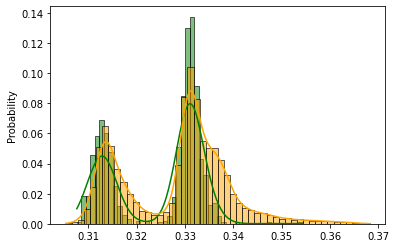

percentile info:  threshold:  0.19565 mean:  0.19698
test rmse info: 0std: 0.00074, 0mean: 0.188841, 1std: 0.00084, 1mean: 0.189215, mean_diff: 0.00037
Epoch [2/20] loss: 0.52224 val_loss: 0.40297 gender0 mse: 0.18846 gender1mse: 0.18965 threshold: 65  f1: 0.0000000   train_acc:1.00000   test_acc: 0.0222241
0.18847409 0.18965454
****************************** Learning Rate:  2e-05 ******************************


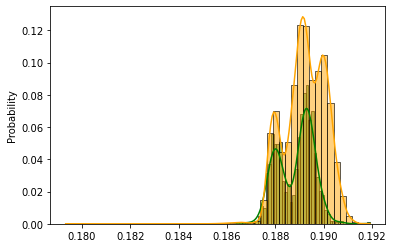

percentile info:  threshold:  0.18312 mean:  0.18264
test rmse info: 0std: 0.00066, 0mean: 0.182892, 1std: 0.00104, 1mean: 0.183597, mean_diff: 0.00071
Epoch [3/20] loss: 0.38146 val_loss: 0.36133 gender0 mse: 0.18351 gender1mse: 0.18363 threshold: 65  f1: 0.7345926   train_acc:0.86857   test_acc: 0.5894712
0.18352221 0.18364199
****************************** Learning Rate:  2e-05 ******************************


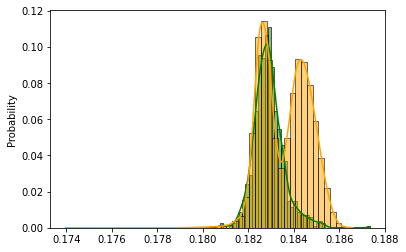

percentile info:  threshold:  0.18097 mean:  0.18068
test rmse info: 0std: 0.00093, 0mean: 0.180787, 1std: 0.00148, 1mean: 0.1818, mean_diff: 0.00101
Epoch [4/20] loss: 0.33358 val_loss: 0.26082 gender0 mse: 0.18193 gender1mse: 0.18168 threshold: 65  f1: 0.7619659   train_acc:0.77176   test_acc: 0.6232952
0.18195422 0.18170857
****************************** Learning Rate:  2e-05 ******************************


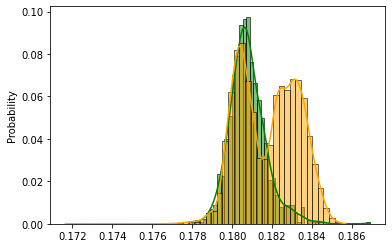

percentile info:  threshold:  0.17992 mean:  0.17968
test rmse info: 0std: 0.00111, 0mean: 0.179694, 1std: 0.00195, 1mean: 0.181061, mean_diff: 0.00137
Epoch [5/20] loss: 0.28635 val_loss: 0.22394 gender0 mse: 0.18127 gender1mse: 0.18089 threshold: 65  f1: 0.7535807   train_acc:0.78371   test_acc: 0.6126060
0.18130112 0.18091822
****************************** Learning Rate:  2e-05 ******************************


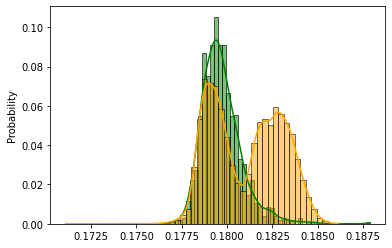

percentile info:  threshold:  0.17923 mean:  0.179
test rmse info: 0std: 0.0013, 0mean: 0.179124, 1std: 0.00218, 1mean: 0.180665, mean_diff: 0.00154
Epoch [6/20] loss: 0.25494 val_loss: 0.19935 gender0 mse: 0.18114 gender1mse: 0.18033 threshold: 65  f1: 0.7995468   train_acc:0.71056   test_acc: 0.6722317
0.18116437 0.18036918
****************************** Learning Rate:  2e-05 ******************************


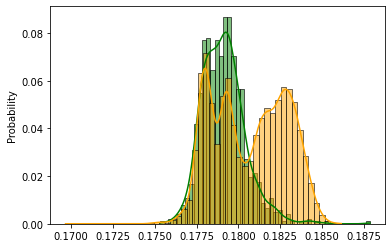

percentile info:  threshold:  0.17872 mean:  0.17852
test rmse info: 0std: 0.00144, 0mean: 0.178674, 1std: 0.00241, 1mean: 0.180385, mean_diff: 0.00171
Epoch [7/20] loss: 0.23278 val_loss: 0.18786 gender0 mse: 0.18095 gender1mse: 0.17999 threshold: 65  f1: 0.8113615   train_acc:0.67886   test_acc: 0.6883849
0.18098159 0.18003044
****************************** Learning Rate:  2e-05 ******************************


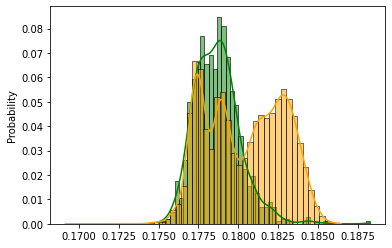

percentile info:  threshold:  0.1783 mean:  0.17811
test rmse info: 0std: 0.00158, 0mean: 0.178228, 1std: 0.0027, 1mean: 0.18015, mean_diff: 0.00192
Epoch [8/20] loss: 0.20984 val_loss: 0.15660 gender0 mse: 0.18068 gender1mse: 0.17977 threshold: 65  f1: 0.7945143   train_acc:0.68764   test_acc: 0.6655537
0.18072031 0.17981187
****************************** Learning Rate:  2e-05 ******************************


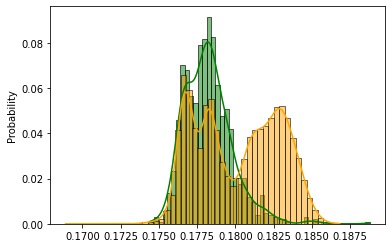

percentile info:  threshold:  0.17794 mean:  0.17778
test rmse info: 0std: 0.00169, 0mean: 0.178045, 1std: 0.00285, 1mean: 0.180061, mean_diff: 0.00202
Epoch [9/20] loss: 0.19386 val_loss: 0.18488 gender0 mse: 0.18067 gender1mse: 0.17963 threshold: 65  f1: 0.8161813   train_acc:0.63228   test_acc: 0.6949112
0.18070535 0.17967835
****************************** Learning Rate:  2e-05 ******************************


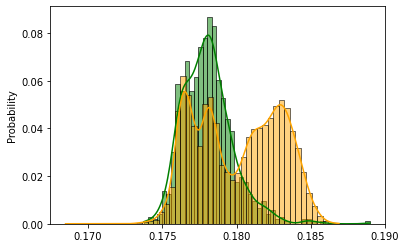

percentile info:  threshold:  0.17764 mean:  0.1775
test rmse info: 0std: 0.00182, 0mean: 0.177629, 1std: 0.00306, 1mean: 0.179812, mean_diff: 0.00218
Epoch [10/20] loss: 0.17977 val_loss: 0.13071 gender0 mse: 0.18047 gender1mse: 0.17934 threshold: 65  f1: 0.8095372   train_acc:0.64960   test_acc: 0.6858698
0.18051423 0.1793955
****************************** Learning Rate:  2e-05 ******************************


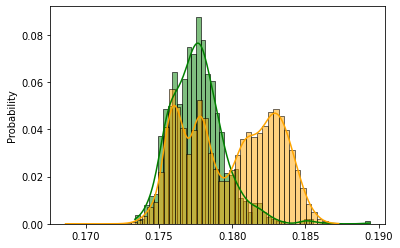

percentile info:  threshold:  0.17737 mean:  0.17723
test rmse info: 0std: 0.00188, 0mean: 0.177566, 1std: 0.00314, 1mean: 0.179795, mean_diff: 0.00223
Epoch [11/20] loss: 0.16362 val_loss: 0.12985 gender0 mse: 0.18045 gender1mse: 0.17933 threshold: 65  f1: 0.8263539   train_acc:0.59571   test_acc: 0.7090696
0.1804895 0.179382
****************************** Learning Rate:  2e-05 ******************************


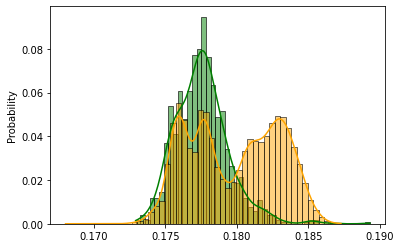

percentile info:  threshold:  0.17715 mean:  0.17701
test rmse info: 0std: 0.00189, 0mean: 0.177425, 1std: 0.00318, 1mean: 0.179698, mean_diff: 0.00227
Epoch [12/20] loss: 0.15205 val_loss: 0.13639 gender0 mse: 0.18040 gender1mse: 0.17920 threshold: 65  f1: 0.8306965   train_acc:0.58254   test_acc: 0.7153357
0.18044256 0.17925578
****************************** Learning Rate:  2e-05 ******************************


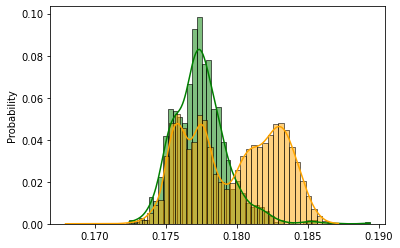

percentile info:  threshold:  0.17694 mean:  0.17681
test rmse info: 0std: 0.00195, 0mean: 0.177176, 1std: 0.00327, 1mean: 0.179507, mean_diff: 0.00233
Epoch [13/20] loss: 0.14136 val_loss: 0.11650 gender0 mse: 0.18014 gender1mse: 0.17905 threshold: 65  f1: 0.8260872   train_acc:0.59205   test_acc: 0.7087227
0.18018244 0.1791063
****************************** Learning Rate:  2e-05 ******************************


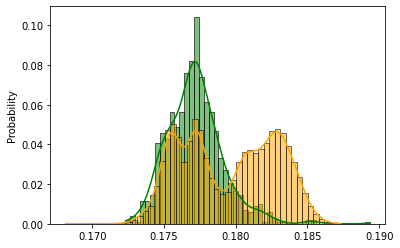

percentile info:  threshold:  0.17676 mean:  0.17662
test rmse info: 0std: 0.00198, 0mean: 0.176874, 1std: 0.00339, 1mean: 0.179303, mean_diff: 0.00243
Epoch [14/20] loss: 0.13131 val_loss: 0.11301 gender0 mse: 0.17986 gender1mse: 0.17889 threshold: 65  f1: 0.8053498   train_acc:0.62009   test_acc: 0.6796904
0.17990644 0.17894506
****************************** Learning Rate:  2e-05 ******************************


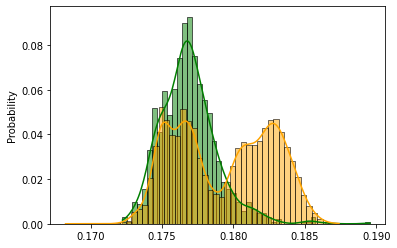

percentile info:  threshold:  0.17657 mean:  0.17647
test rmse info: 0std: 0.00212, 0mean: 0.17698, 1std: 0.00346, 1mean: 0.179426, mean_diff: 0.00245
Epoch [15/20] loss: 0.12364 val_loss: 0.11274 gender0 mse: 0.18017 gender1mse: 0.17890 threshold: 65  f1: 0.8370729   train_acc:0.54084   test_acc: 0.7243989
0.18021406 0.17895775
****************************** Learning Rate:  2e-05 ******************************


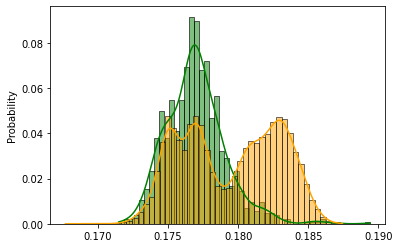

percentile info:  threshold:  0.17647 mean:  0.17633
test rmse info: 0std: 0.00216, 0mean: 0.17682, 1std: 0.00352, 1mean: 0.17931, mean_diff: 0.00249
Epoch [16/20] loss: 0.11859 val_loss: 0.10637 gender0 mse: 0.18001 gender1mse: 0.17881 threshold: 65  f1: 0.8313496   train_acc:0.54475   test_acc: 0.7163765
0.18005332 0.17886871
****************************** Learning Rate:  2e-05 ******************************


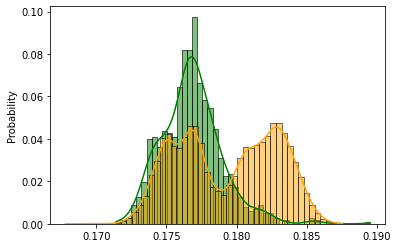

percentile info:  threshold:  0.17634 mean:  0.1762
test rmse info: 0std: 0.00217, 0mean: 0.176618, 1std: 0.00358, 1mean: 0.179156, mean_diff: 0.00254
Epoch [17/20] loss: 0.11040 val_loss: 0.08106 gender0 mse: 0.17978 gender1mse: 0.17870 threshold: 65  f1: 0.8205663   train_acc:0.57035   test_acc: 0.7008521
0.17983021 0.17875637
****************************** Learning Rate:  2e-05 ******************************


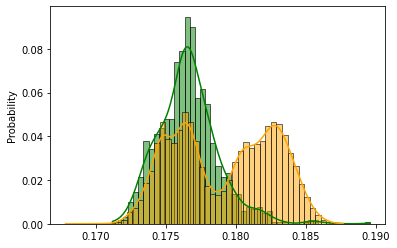

percentile info:  threshold:  0.17619 mean:  0.17606
test rmse info: 0std: 0.00227, 0mean: 0.176485, 1std: 0.00366, 1mean: 0.17906, mean_diff: 0.00258
Epoch [18/20] loss: 0.10220 val_loss: 0.09630 gender0 mse: 0.17965 gender1mse: 0.17862 threshold: 65  f1: 0.8185637   train_acc:0.55986   test_acc: 0.6979033
0.17969732 0.1786821
****************************** Learning Rate:  2e-05 ******************************


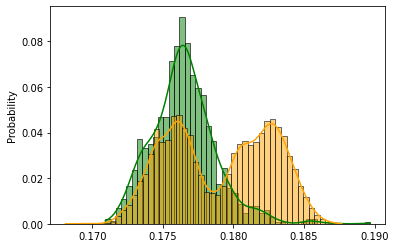

percentile info:  threshold:  0.17611 mean:  0.17596
test rmse info: 0std: 0.00229, 0mean: 0.176337, 1std: 0.00378, 1mean: 0.179015, mean_diff: 0.00268
Epoch [19/20] loss: 0.09808 val_loss: 0.08702 gender0 mse: 0.17946 gender1mse: 0.17866 threshold: 65  f1: 0.8057834   train_acc:0.58742   test_acc: 0.6803192
0.17951329 0.17871934
****************************** Learning Rate:  2e-05 ******************************


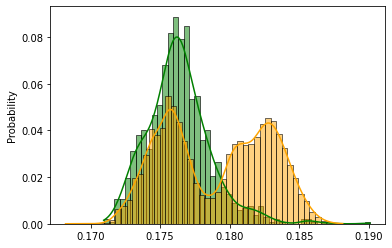

percentile info:  threshold:  0.17598 mean:  0.17587
test rmse info: 0std: 0.00241, 0mean: 0.176589, 1std: 0.00379, 1mean: 0.179236, mean_diff: 0.00265
Epoch [20/20] loss: 0.09251 val_loss: 0.07562 gender0 mse: 0.17997 gender1mse: 0.17870 threshold: 65  f1: 0.8461653   train_acc:0.48695   test_acc: 0.7373214
0.18002538 0.17876796
****************************** Learning Rate:  2e-05 ******************************


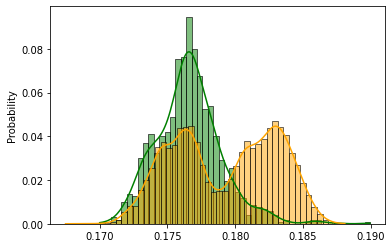

{65: 20}


In [ ]:
def save_checkpoint(state, is_best, outdir):
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    checkpoint_file = os.path.join(outdir, 'checkpoint.pth')
    best_file = os.path.join(outdir, 'model_best.pth')
    torch.save(state, checkpoint_file)
    if is_best:
        shutil.copyfile(checkpoint_file, best_file)



def main(train_data, train_names, dev_data, dev_names):
    parser = argparse.ArgumentParser(description='Explainable VAE MNIST Example')
    #parser.add_argument('--result_dir', type=str, default='/content/drive/MyDrive/11785FinalProject/results/', metavar='DIR',
    #                    help='output directory')
    parser.add_argument('--ckpt_dir', type=str, default='/content/drive/MyDrive/11785FinalProject/results/ckpt.pt', metavar='DIR',
                        help='ckpt directory')
    parser.add_argument('--batch_size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 128)')
    parser.add_argument('--epochs', type=int, default=20, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--resume', default=True, type=str, metavar='PATH',
                        help='path to latest checkpoint (default: None')

    # model options
    parser.add_argument('--latent_size', type=int, default=512, metavar='N',
                        help='latent vector size of encoder')
    parser.add_argument('--one_class', type=int, default=3, metavar='N',
                        help='inlier digit for one-class VAE training')
    parser.add_argument("--fake", type = int, default = 0, metavar = 'N', help = "d")

    args, unknown = parser.parse_known_args()

    torch.manual_seed(args.seed)
    train_gender_dict = {'LA_0079': 'f', 'LA_0098': 'f', 'LA_0089': 'u-m', 'LA_0088': 'f', 'LA_0087': 'f', 'LA_0086': 'f', 'LA_0085': 'f', 'LA_0084': 'f', 'LA_0083': 'm', 'LA_0082': 'm', 'LA_0081': 'f', 'LA_0080': 'f', 'LA_0090': 'f', 'LA_0097': 'f', 'LA_0092': 'm', 'LA_0095': 'm', 'LA_0094': 'u-m', 'LA_0093': 'm', 'LA_0096': 'm', 'LA_0091': 'f'}
    dev_gender_dict = {'LA_0069': 'f', 'LA_0070': 'm', 'LA_0071': 'm', 'LA_0072': 'f', 'LA_0073': 'm', 'LA_0074': 'f', 'LA_0075': 'f', 'LA_0076': 'm', 'LA_0077': 'f', 'LA_0078': 'f', 'LA_0099': 'm', 'LA_0100': 'm', 'LA_0101': 'm', 'LA_0102': 'f', 'LA_0103': 'f', 'LA_0104': 'f', 'LA_0105': 'm', 'LA_0106': 'f', 'LA_0107': 'f', 'LA_0108': 'f'}

    gender_dict = {**train_gender_dict, **dev_gender_dict}

    keys_t = pd.read_csv('/content/drive/MyDrive/11785FinalProject/data/ASVspoof2019.LA.cm.train.trn.txt', sep=" ")#=["name", "data","None", "Device", "Bona"])
    keys_d = pd.read_csv('/content/drive/MyDrive/11785FinalProject/data/ASVspoof2019.LA.cm.dev.trl.txt', sep=" ")#=["name", "data","None", "Device", "Bona"])
    keys_t = keys_t.rename(columns={'LA_0079': 'Speaker', 'LA_T_1138215': 'Filename', '-': "-", "-.1":"Device", "bonafide": "bonafide"})
    keys_d = keys_d.rename(columns={'LA_0069': 'Speaker', 'LA_D_1047731': 'Filename', '-': "-", "-.1":"Device", "bonafide": "bonafide"})
    keys = keys_t.append(keys_d, ignore_index=True)

    kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

    #t_f_files: train fake files
    #t_b_files: train bonafide files
    #d_f_files: dev fake files
    #d_b_files: dev bonafide files
    val_ratio = 0.2
    torch.cuda.empty_cache()
    #For training on Bonafide
    train_data = MelBankDataset(b_files, b_names, keys, crop_size = (-1,63), dtype = None, gender_dict = gender_dict, colname = "Filename")
    valid_data = MelBankDataset(f_files, f_names, keys, crop_size = (-1,63), dtype = None, gender_dict = gender_dict, colname = "Filename")
    valids = int(len(train_data) * val_ratio)
    train_data, valid_data_b = torch.utils.data.random_split(train_data, [len(train_data) - valids, valids])

    valids = int(len(valid_data) * 0.3)
    valid_data_f, unused = torch.utils.data.random_split(valid_data, [len(valid_data) - valids, valids])

    combined_val = torch.utils.data.ConcatDataset([valid_data_b, valid_data])
    
    """
    #For training on Fake
    valid_data = MelBankDataset(b_files, b_names, keys, crop_size = (-1,63), dtype = None, gender_dict = gender_dict, colname = "Filename")
    train_data = MelBankDataset(f_files, f_names, keys, crop_size = (-1,63), dtype = None, gender_dict = gender_dict, colname = "Filename")

    valids = int(len(train_data) * val_ratio * 1.5)
    train_data, valid_data_f = torch.utils.data.random_split(train_data, [len(train_data) - valids, valids])

    combined_val = torch.utils.data.ConcatDataset([valid_data, valid_data_f]) """

    """only use portion of fake data because there are 10 times more fake data than bonafide"""

    path = "/content/drive/MyDrive/11785FinalProject/model_main.pt"
    
    train_loader = DataLoader(train_data, batch_size= args.batch_size, num_workers = 4, shuffle = True)
    val_loader = DataLoader(combined_val, batch_size = args.batch_size, shuffle = True, num_workers = 4)

    model = ConvVAE(args.latent_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=2e-5)

    retrieve_model =False

    if(retrieve_model):
      checkpoint = torch.load(path)
      model.load_state_dict(checkpoint["model_state_dict"])
      optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    
    start_epoch = 0
    best_test_loss = np.finfo('f').max
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 3, factor = 0.5)
    
    best_loss = 100
    thresholds = [65] # [75,80,85]
    dic = dict()
    test_accs,train_accs, test_f1s, train_f1s = dict(),[],dict(),[]
    train_losses, test_losses = [], dict()
    rmse_real_list, rmse_fake_list = dict(), dict()
    mean_diffs = dict()

    for epoch in range(start_epoch, args.epochs):
        thres = 75
        train_loss,rmse_real, g0mse, g1mse = train(epoch, model, train_loader, optimizer, args, device)
        _,valid_acc, _, _, _, _ ,_, _,_, _ = valid(epoch, model, train_loader,args, rmse_real, device, thres)
        #epoch_val_loader = val_loader[:len(val_loader)*0.6]
        cur_acc = 0
        for thres in thresholds:
          test_loss,test_acc, test_auc, f1, rmse_fake, rmse_real_ ,g0mse, g1mse,rmse_male, rmse_female, rmse_fake_m, rmse_fake_f = test(epoch, model, val_loader,args, rmse_real, device, thres)
          if(thres not in test_accs):
            test_f1s[thres] = [f1]
            rmse_fake_list[thres] = [rmse_fake]
            rmse_real_list[thres] = [rmse_real]
            test_losses[thres] = [test_loss]
            test_accs[thres] =[test_acc]
          else:
            test_accs[thres].append(test_acc)
            test_f1s[thres].append(f1)
            rmse_fake_list[thres].append(rmse_fake)
            rmse_real_list[thres].append(rmse_real)
            test_losses[thres].append(test_loss)
          if(test_acc > cur_acc):
            epoch_loss, epoch_acc, epoch_auc, epoch_f1, epoch_rmse_fake, epoch_rmse_real, epoch_g0mse, epoch_g1mse,e_rmse_male, e_rmse_female = test_loss,test_acc, test_auc, f1, rmse_fake, rmse_real_, g0mse, g1mse,rmse_male, rmse_female
            best_thres = thres
            cur_acc = test_acc

        if(best_thres in dic):
          dic[best_thres] +=1
        else:
          dic[best_thres] = 1
        #return rmse_real, rmse_fake
        flat_male = [item for sublist in e_rmse_male for item in sublist]
        flat_female = [item for sublist in e_rmse_female for item in sublist]
        #pdb.set_trace()
        print("test rmse info: 0std: {}, 0mean: {}, 1std: {}, 1mean: {}, mean_diff: {}".format(round(np.std(epoch_rmse_real),5), round(np.mean(epoch_rmse_real),6), round(np.std(epoch_rmse_fake),5), round(np.mean(epoch_rmse_fake),6), round(np.mean(epoch_rmse_fake)-np.mean(epoch_rmse_real), 5)))
        print('Epoch [%d/%d] loss: %.5f val_loss: %.5f gender0 mse: %.5f gender1mse: %.5f threshold: %d  f1: %.7f   train_acc:%.5f   test_acc: %.7f' % (epoch + 1, args.epochs, train_loss, epoch_loss, np.mean(flat_male), np.mean(flat_female),best_thres, epoch_f1, valid_acc, epoch_acc))
        print(np.asarray(rmse_fake_m).mean(), np.asarray(rmse_fake_f).mean())
        print("**" * 15, "Learning Rate: ", optimizer.param_groups[0]['lr'], "**" * 15)
        #is_best = test_loss < best_test_loss

        flat_real = [item for sublist in epoch_rmse_real for item in sublist]
        flat_fake = [item for sublist in epoch_rmse_fake for item in sublist]
        plt.clf()
        sns.histplot(data=flat_real, bins = 50, stat = "probability", color = "Green", kde = True)
        sns.histplot(data = flat_fake, bins = 50, stat = "probability", color = "Orange", kde = True)
        plt.show()

        train_accs.append(valid_acc)

        train_losses.append(train_loss)
        #test_losses.append(epoch_loss)

        if(test_loss < best_loss):
          torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
          best_loss= test_loss
        scheduler.step(test_loss)
        #np.save('/content/drive/MyDrive/11785FinalProject/rmse_fake.npy', rmse_fake_list)
        #np.save('/content/drive/MyDrive/11785FinalProject/rmse_real.npy', rmse_real_list)
        #np.save('/content/drive/MyDrive/11785FinalProject/test_losses.npy', test_losses)
        #np.save('/content/drive/MyDrive/11785FinalProject/test_accs.npy', test_accs)
        #np.save('/content/drive/MyDrive/11785FinalProject/test_f1s.npy', test_f1s)
        #np.save('/content/drive/MyDrive/11785FinalProject/train_losses.npy', train_losses)
        #np.save('/content/drive/MyDrive/11785FinalProject/train_accs.npy', train_accs)
    print(dic)
    return rmse_real_list, rmse_fake_list, train_accs, test_accs, train_f1s, test_f1s, train_losses, test_losses


rmse_real, rmse_fake, train_accs, test_accs, train_f1s, test_f1s, train_losses, test_losses = main(train_data, train_names, dev_data, dev_names)

In [ ]:
rfake = np.load('/content/drive/MyDrive/11785FinalProject/rmse_fake.npy', allow_pickle = True)
rreal = np.load('/content/drive/MyDrive/11785FinalProject/rmse_real.npy', allow_pickle = True)
test_losses =np.load('/content/drive/MyDrive/11785FinalProject/test_losses.npy', allow_pickle = True)
test_accs =np.load('/content/drive/MyDrive/11785FinalProject/test_accs.npy', allow_pickle = True)
test_f1s = np.load('/content/drive/MyDrive/11785FinalProject/test_f1s.npy', allow_pickle= True)
train_losses = np.load('/content/drive/MyDrive/11785FinalProject/train_losses.npy', allow_pickle = True)
train_accs = np.load('/content/drive/MyDrive/11785FinalProject/train_accs.npy', allow_pickle = True)

In [ ]:
test_accs.item()

([<matplotlib.axis.XTick at 0x7f94a4b3b8d0>,
 <a list of 20 Text major ticklabel objects>)

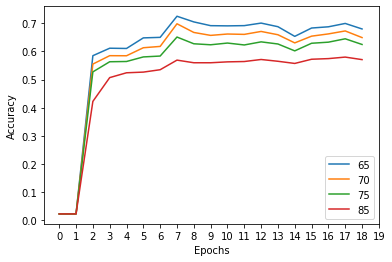

In [ ]:
sns.lineplot(y =test_accs.item()[65][1:-1], x = list(range(19)))
sns.lineplot(y = test_accs.item()[70][1:-1], x = list(range(19)))
sns.lineplot(y = test_accs.item()[75][1:-1], x = list(range(19)))
sns.lineplot(y = test_accs.item()[85][1:-1], x = list(range(19)))
plt.legend(labels = ["65", "70", "75", "85"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(np.arange(0,20,1.0))


In [ ]:
sns.lineplot(y =test_f1s.item()[65][1:-1], x = list(range(19)))
sns.lineplot(y = test_f1s.item()[70][1:-1], x = list(range(19)))
sns.lineplot(y = test_f1s.item()[75][1:-1], x = list(range(19)))
sns.lineplot(y = test_f1s.item()[85][1:-1], x = list(range(19)))
plt.legend(labels = ["65", "70", "75", "85"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(np.arange(0,20,1.0))

In [ ]:
train_losses[0]

48.266351059511564

([<matplotlib.axis.XTick at 0x7f94a4811c90>,
 <a list of 20 Text major ticklabel objects>)

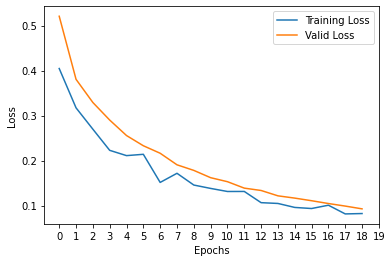

In [ ]:
sns.lineplot(y = test_losses.item()[65][2:], x = list(range(19)) )
sns.lineplot(y = train_losses[1:], x = list(range(19)))
plt.legend(labels = ["Training Loss", "Valid Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,20,1.0))

([<matplotlib.axis.XTick at 0x7f94a4339890>,
 <a list of 20 Text major ticklabel objects>)

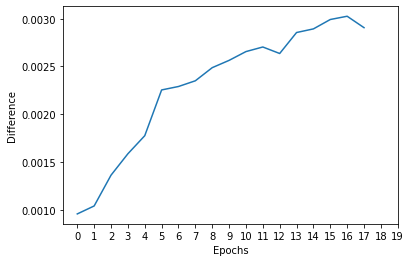

In [ ]:
rmse_fake, rmse_real = rfake, rreal

rf65 = np.asarray(rmse_fake.item()[65]).mean(axis = 1).flatten()
rr65 = np.asarray(rmse_real.item()[65]).mean(axis = 1)
rmse_diff65 = rf65 - rr65

sns.lineplot(y = rmse_diff65[3:], x = list(range(18)))
plt.xlabel("Epochs")
plt.ylabel("Difference")
plt.xticks(np.arange(0,20,1.0))

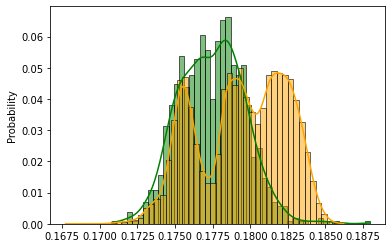

In [ ]:
#print(len(rmse_fake))
#if(epoch % 10 == 0):

#Fake data from many sources

# Get both train/test accuracies


#print("plot"

flat_real = [item for sublist in rmse_real for item in sublist]
flat_fake = [item for sublist in rmse_fake for item in sublist]
sns.histplot(data=flat_real, bins = 50, stat = "probability", color = "Green", kde = True)
sns.histplot(data = flat_fake, bins = 50, stat = "probability", color = "Orange", kde = True)

In [ ]:
print(np.ones(len(rmse_real)).shape)

(1025,)


In [ ]:
#Identify model divergence by checking loss, reconstructed_x, and appropriately modified learning rate to fix.
#Because of data imbalance, need to use FPR/TPR, ROC AUC or EER. These tests need probabilities, but we have been using a threshold to determine 1/0. 
# Using the array of RMSE from training, create a normal distribution with its mean and variance, and test the RMSE from validation phase 
# to determine if it came from that distribution.
# Should we train on bonafide or fake in the presence of imbalanced data

In [ ]:
#TODO:
# check input data shape and add layers. 
# Input shape: (BatchSize, Channel (1), Time (40), Frequency (200))

# Different latent size, Different layers, Different Thresholds
# Show g0mse, g1mse
#Run testing function for different thresholds every epoch

# Dropout
# Loop over thresholds
# Show histograms
# Train on fake data
# Identify why original paper trained only on real data
# early stopping criteria could be accuracy:

# Reconstruction of true data is also fake
# 

In [ ]:
"""from python_speech_features import logfbank, fbank
from scipy.io import wavfile
def get_feature(file_name):
  rate, data = wavfile.read(file_name)
  output, _ = fbank(data,samplerate=rate, winlen=0.025625,
                    winstep=0.01, nfilt=40, nfft=512,
                    lowfreq=100, highfreq=3800, winfunc=np.hamming)
  output = np.log(output)
  return output
#Save to matrix using np.save, keep names as function arg.
#2nd column of csv is filename.
#Using dataloader"""
"""
path = "/root/content/drive/MyDrive/11785FinalProject/data/train/"
dev_path = "/root/content/drive/MyDrive/11785FinalProject/data/dev/"
train_list = os.listdir("/content/drive/MyDrive/11785FinalProject/data/train/")
#dev_list = os.listdir("/root/content/drive/MyDrive/11785FinalProject/data/dev/")
filenames = []
npys = []
for file in train_list:
  filenames.append(file[:-4])
  #npys.append(get_feature(path + file))"""